## ***Clean GPU***

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

## ***Packages***

In [ ]:
import torch
import torch.nn as nn 
import torch.optim as optim 
from torchvision import datasets 
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset # to custom class dataset
from torchvision.io import read_image # ?
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import Image
import random
import datetime
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


## ***Build Dataset***

In [ ]:
my_transform = transforms.Compose([
                                   transforms.Resize((256, 256)),
                                   transforms.ToTensor()
                                  ])

In [ ]:
path_image_cleaned = "/content/drive/MyDrive/Colab Notebooks/UTEC - IA/data/project6/train_cleaned"
path_image_train = "/content/drive/MyDrive/Colab Notebooks/UTEC - IA/data/project6/train"
path_image_test = "/content/drive/MyDrive/Colab Notebooks/UTEC - IA/data/project6/test"
path_models = "/content/drive/MyDrive/Colab Notebooks/UTEC - IA/models/"

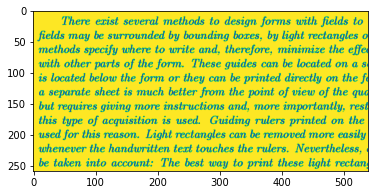

In [ ]:
img = read_image(path_image_cleaned+"/2.png")
plt.imshow(img.squeeze())

In [ ]:
def load_images_from_folder(folder, my_transform):
    data = []
    for f in sorted(os.listdir(folder + '/')):
        img = Image.open(folder + '/' + f)
        img = my_transform(img)
        img = img.squeeze()
        data.append(img.type(torch.float32))
    return data

In [ ]:
data_cleaned = load_images_from_folder(path_image_cleaned, my_transform)
data_train = load_images_from_folder(path_image_train, my_transform)
data_test = load_images_from_folder(path_image_test, my_transform)

In [ ]:
tensor_cleaned = torch.stack(data_cleaned)
tensor_train = torch.stack(data_train)
tensor_test = torch.stack(data_test)

In [ ]:
shape_img = data_test[0].shape
shape_img

torch.Size([256, 256])

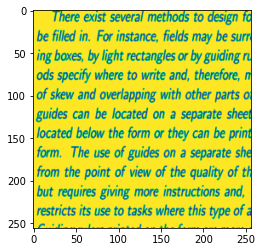

In [ ]:
plt.imshow(tensor_cleaned[0])

In [ ]:
data_cleaned[0].shape

torch.Size([256, 256])

In [ ]:
def check_size(data_file):
  minx, miny, maxx, maxy = 1000, 1000, 0, 0
  for img in data_file:
    minx = min(minx, img.shape[0])
    miny = min(miny, img.shape[1])
    maxx = max(maxx, img.shape[0])
    maxy = max(maxy, img.shape[1])
  print(minx,miny,maxx,maxy)

In [ ]:
index= np.arange(0,tensor_cleaned.shape[0])
torch_index = torch.from_numpy(index)
torch_index
#tensor_train.shape

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143])

In [ ]:
#train_loader = DataLoader(data_train, shuffle=False, batch_size= 4)
#cleaned_loader = DataLoader(data_cleaned, shuffle=False, batch_size= 4)
index_loader = DataLoader(torch_index, shuffle=True, batch_size= 4)

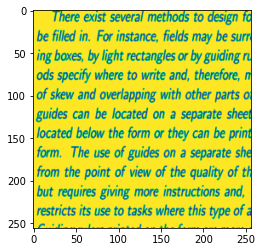

In [ ]:
plt.imshow(data_cleaned[0])

## ***Model MLP***

In [ ]:
class AutoencoderMLP(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 1500),
            nn.ReLU(),
            nn.Linear(1500, 4000),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(4000, 1500),
            nn.ReLU(),
            nn.Linear(1500, input_shape),
            nn.Sigmoid(),
        )

    def forward(self, input):
        out = self.encoder(input)
        out = self.decoder(out)
        return out

In [ ]:
class AutoencoderMLP2(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 1500),
            nn.BatchNorm1d(1500),
            nn.LeakyReLU(),
            #nn.Dropout(p = 0.2),
            nn.Linear(1500, 1500),
            nn.BatchNorm1d(1500),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1500),
            #nn.Dropout(p = 0.2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(1500, 1500),
            nn.BatchNorm1d(1500),
            nn.LeakyReLU(),
            #nn.Dropout(p = 0.2),
            nn.Linear(1500, input_shape),
            #nn.BatchNorm1d(input_shape),
            nn.Sigmoid(),
        )

    def forward(self, input):
        out = self.encoder(input)
        out = self.decoder(out)
        return out

## ***Traning and Validate Functions***

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, index_loader, t_train, t_cleaned, features):
  errors = []
  accuracies = []
  tran1_tmp = transforms.ToPILImage()
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    
    for ind in index_loader:
      #plt.imshow(imgs[0].permute(1, 2, 0))
      #plt.show()
      imgs = t_train[ind]
      img_out = imgs[0]
      imgs = imgs.view(-1, features[0]*features[1]).to(device)
      out = t_cleaned[ind]
      out_out = out[0]
      out = out.view(-1, features[0]*features[1]).to(device)
      #print(imgs.shape)
      outputs = model(imgs)
      
      loss = loss_fn(outputs, out)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_train += loss.item()

    if epoch == 1 or epoch % 10 == 0:
      print('{} Epoch {}, Training loss {}'.format( datetime.datetime.now(), epoch, 
                                                   loss_train / t_train.shape[0]))  
      errors.append(loss_train / t_train.shape[0])
      out2 = outputs[0]
      out2 = out2.view(features[0],features[1]).to("cpu")
      display(tran1_tmp(img_out))
      display(tran1_tmp(out2))
      
      #val = validate_age(model, t_train, t_cleaned, k_value)
      #accuracies.append(val)
  return errors, accuracies

## ***Training Model MLP***

In [ ]:
model = AutoencoderMLP(input_shape=shape_img[0]*shape_img[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.MSELoss()

In [ ]:
#model
weights = sum(p.numel() for p in model.parameters())
weights/10**6

208.680536

In [ ]:
model

AutoencoderMLP(
  (encoder): Sequential(
    (0): Linear(in_features=65536, out_features=1500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1500, out_features=4000, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=4000, out_features=1500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1500, out_features=65536, bias=True)
    (3): Sigmoid()
  )
)

2021-08-04 19:51:14.863170 Epoch 1, Training loss 0.0432773180719879


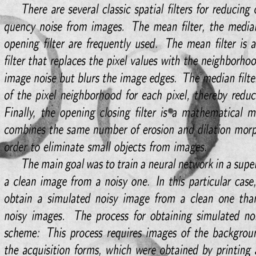

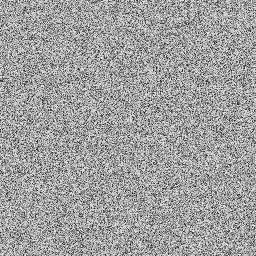

2021-08-04 19:51:29.014676 Epoch 10, Training loss 0.008805067925196555


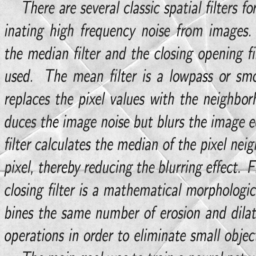

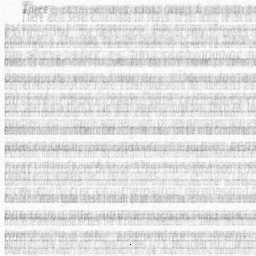

2021-08-04 19:51:44.741213 Epoch 20, Training loss 0.007434983414390849


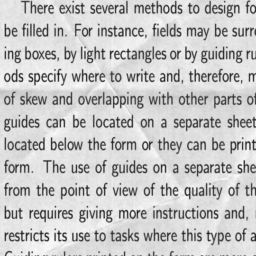

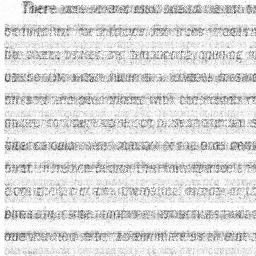

2021-08-04 19:52:00.462449 Epoch 30, Training loss 0.005914993441870643


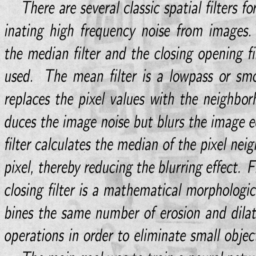

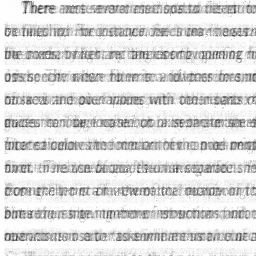

2021-08-04 19:52:16.188427 Epoch 40, Training loss 0.005579099718791743


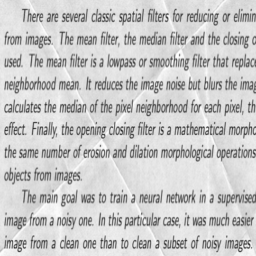

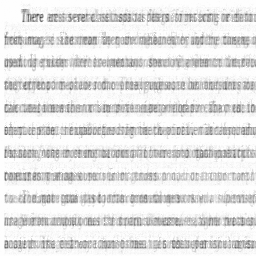

2021-08-04 19:52:31.936488 Epoch 50, Training loss 0.005422219634056091


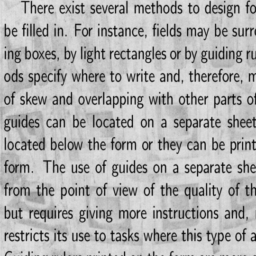

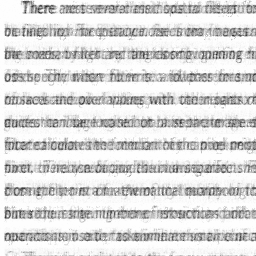

2021-08-04 19:52:47.668243 Epoch 60, Training loss 0.005274182793477343


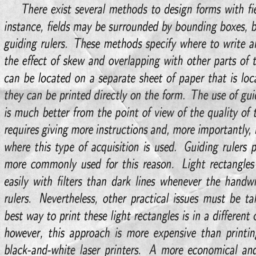

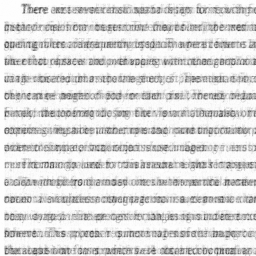

2021-08-04 19:53:03.410951 Epoch 70, Training loss 0.0050528078831525314


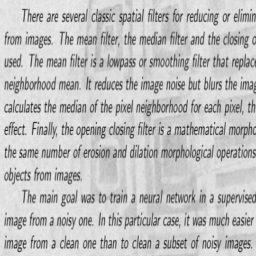

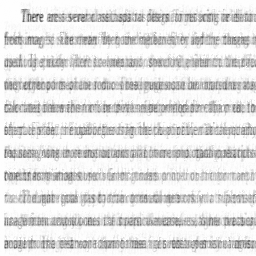

2021-08-04 19:53:19.154597 Epoch 80, Training loss 0.004721137268158297


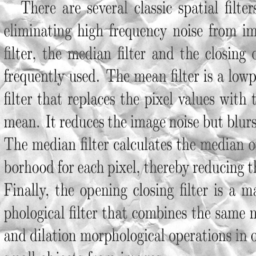

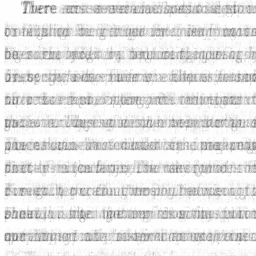

2021-08-04 19:53:34.883420 Epoch 90, Training loss 0.004290627613146272


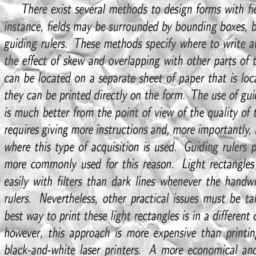

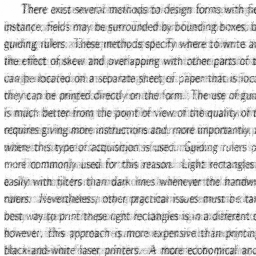

2021-08-04 19:53:50.627386 Epoch 100, Training loss 0.003923415924267222


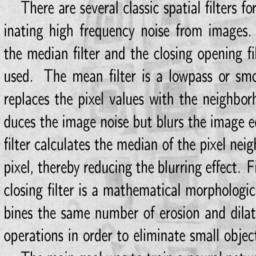

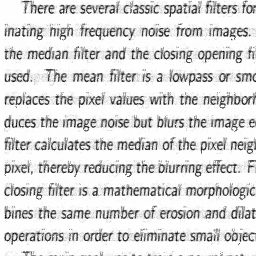

2021-08-04 19:54:06.364450 Epoch 110, Training loss 0.003607369784731418


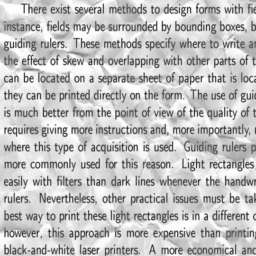

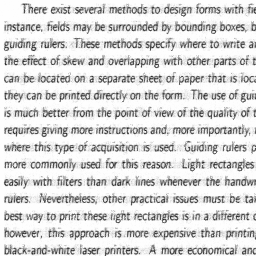

2021-08-04 19:54:22.107158 Epoch 120, Training loss 0.0033284959758424926


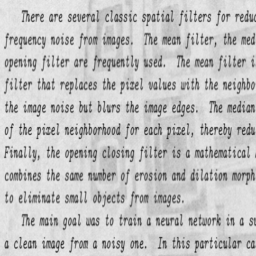

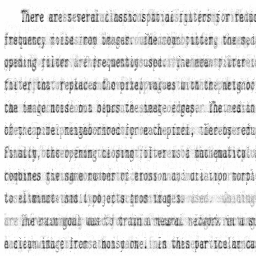

2021-08-04 19:54:37.817580 Epoch 130, Training loss 0.003078149832112508


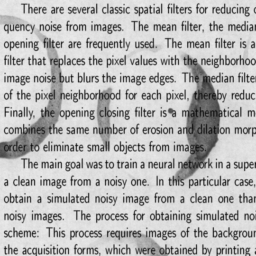

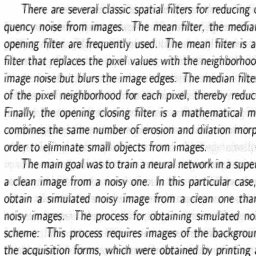

2021-08-04 19:54:53.539431 Epoch 140, Training loss 0.002825855115790748


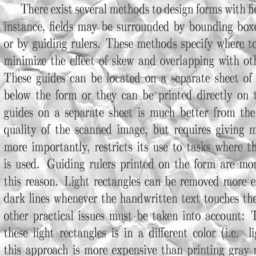

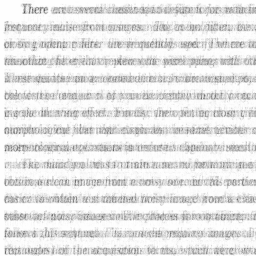

2021-08-04 19:55:09.276000 Epoch 150, Training loss 0.002618203667225316


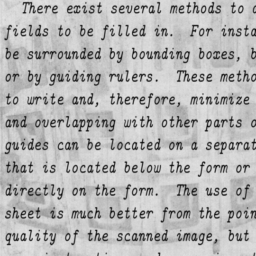

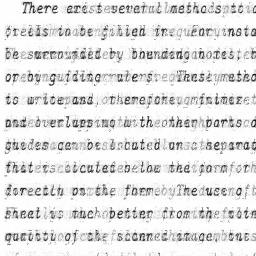

2021-08-04 19:55:25.011970 Epoch 160, Training loss 0.0024231645640813643


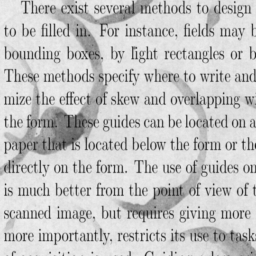

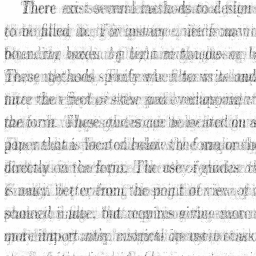

2021-08-04 19:55:40.734971 Epoch 170, Training loss 0.00224703578149072


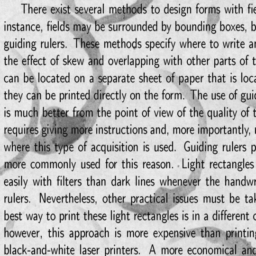

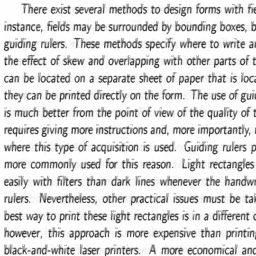

2021-08-04 19:55:56.462353 Epoch 180, Training loss 0.0020804347942531523


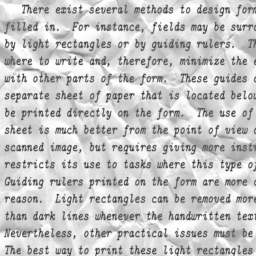

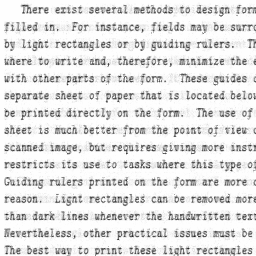

2021-08-04 19:56:12.201595 Epoch 190, Training loss 0.0019314613924103065


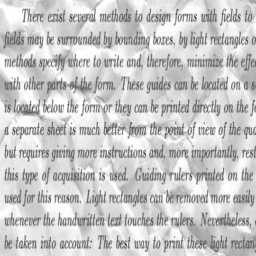

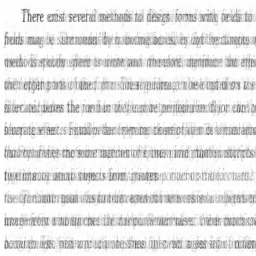

2021-08-04 19:56:27.949859 Epoch 200, Training loss 0.0017948940706749756


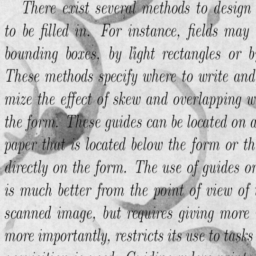

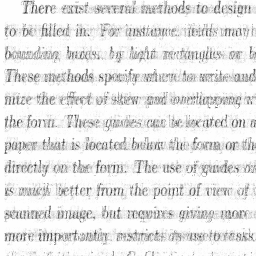

2021-08-04 19:56:43.686333 Epoch 210, Training loss 0.001663125297960101


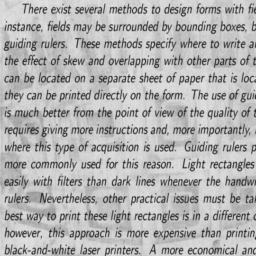

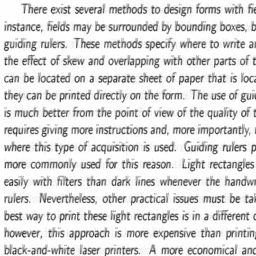

2021-08-04 19:56:59.417785 Epoch 220, Training loss 0.0015431236582420145


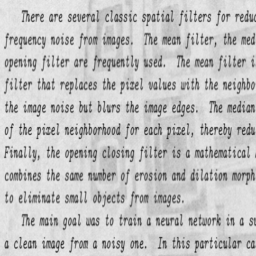

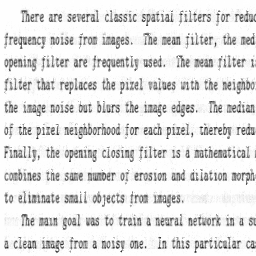

2021-08-04 19:57:15.159237 Epoch 230, Training loss 0.001404897104496033


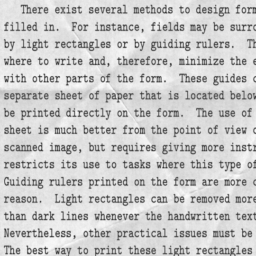

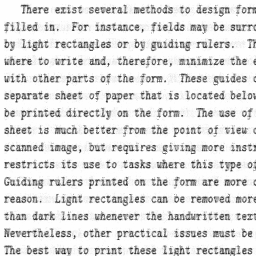

2021-08-04 19:57:30.914926 Epoch 240, Training loss 0.0012726681727346862


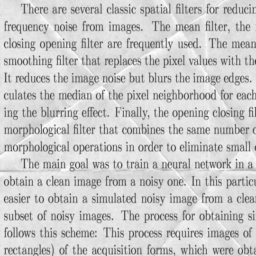

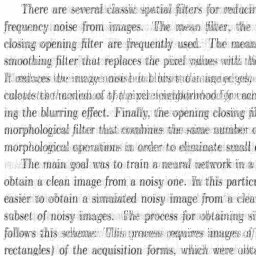

2021-08-04 19:57:46.652843 Epoch 250, Training loss 0.0011443543464540401


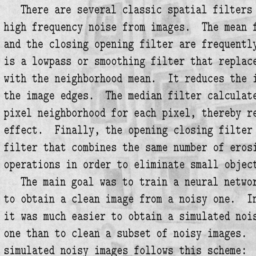

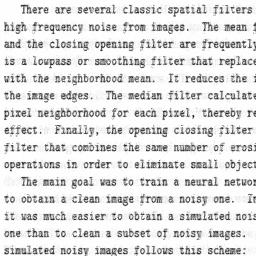

2021-08-04 19:58:02.388988 Epoch 260, Training loss 0.001029813198126956


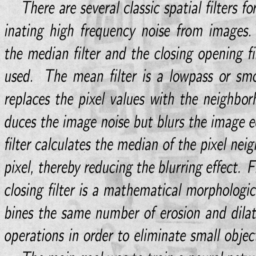

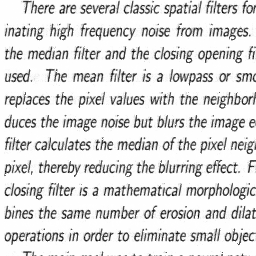

2021-08-04 19:58:18.117168 Epoch 270, Training loss 0.0009262518853776985


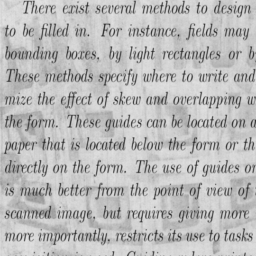

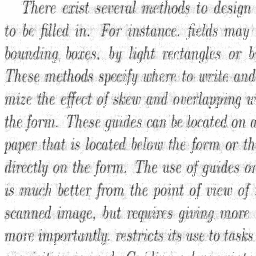

2021-08-04 19:58:33.863832 Epoch 280, Training loss 0.0008279824865490405


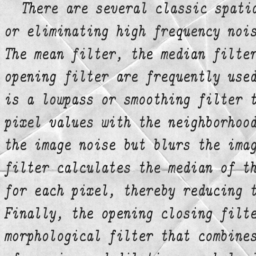

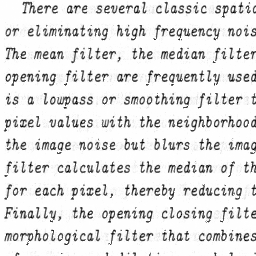

2021-08-04 19:58:49.606926 Epoch 290, Training loss 0.0007335244129838733


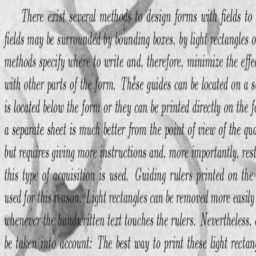

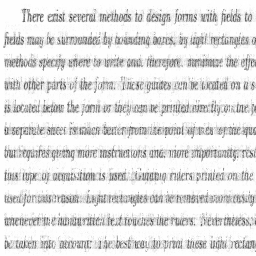

2021-08-04 19:59:05.359481 Epoch 300, Training loss 0.0006499485284115912


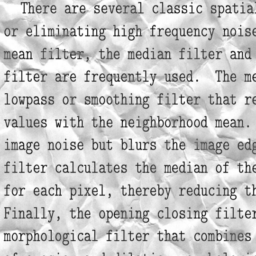

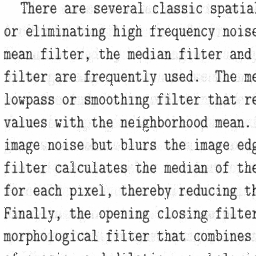

2021-08-04 19:59:21.104705 Epoch 310, Training loss 0.0005687839293386787


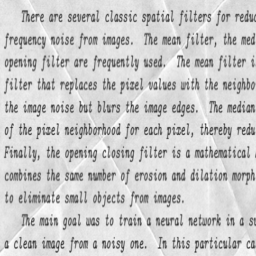

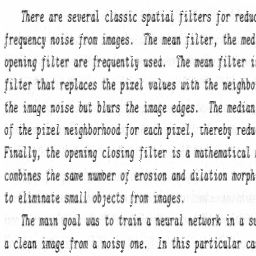

2021-08-04 19:59:36.836337 Epoch 320, Training loss 0.0005114602528111492


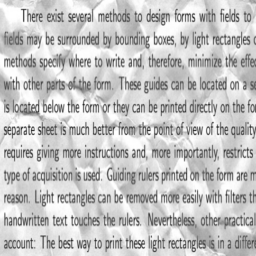

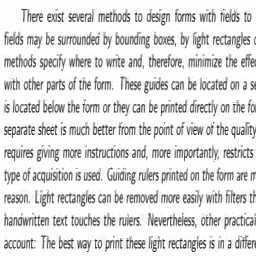

2021-08-04 19:59:52.576051 Epoch 330, Training loss 0.00045739524001773033


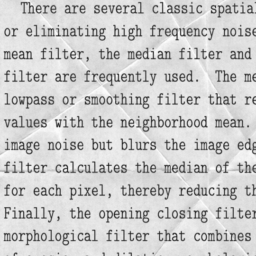

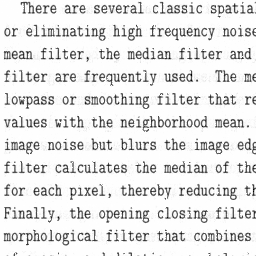

2021-08-04 20:00:08.334410 Epoch 340, Training loss 0.0004185821251465111


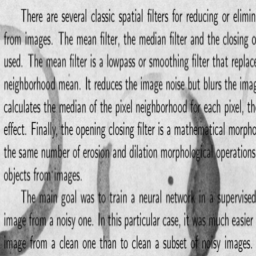

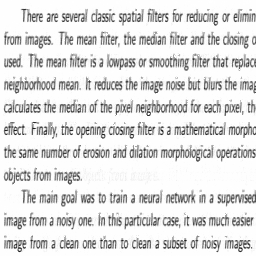

2021-08-04 20:00:24.094991 Epoch 350, Training loss 0.0003645204827383471


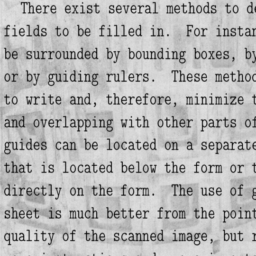

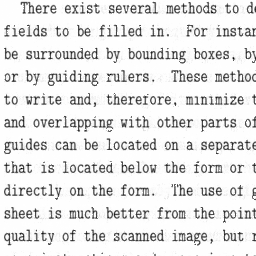

2021-08-04 20:00:39.825377 Epoch 360, Training loss 0.0003350414230630526


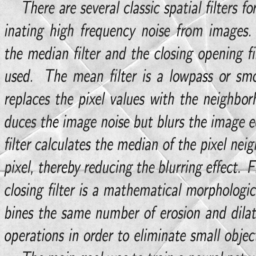

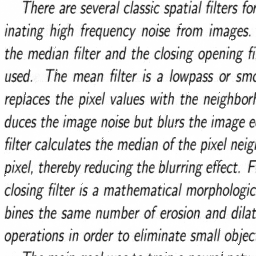

2021-08-04 20:00:55.551632 Epoch 370, Training loss 0.00030563875690050836


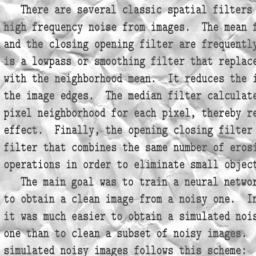

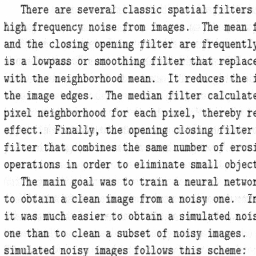

2021-08-04 20:01:11.281946 Epoch 380, Training loss 0.0002823307368089445


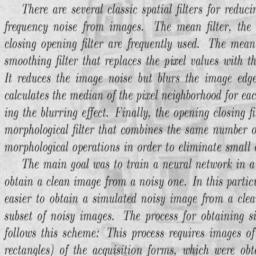

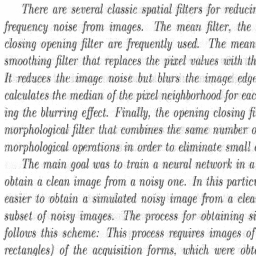

2021-08-04 20:01:27.018476 Epoch 390, Training loss 0.00026152396902842965


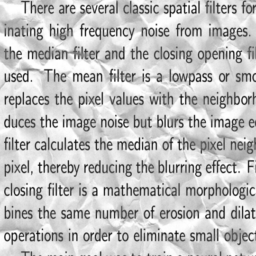

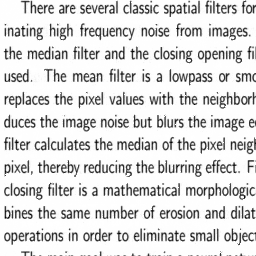

2021-08-04 20:01:42.752322 Epoch 400, Training loss 0.00023930649452571137


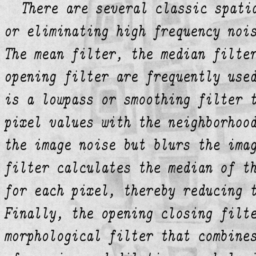

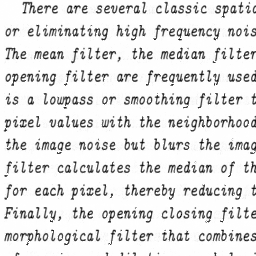

2021-08-04 20:01:58.477223 Epoch 410, Training loss 0.0002193275635767754


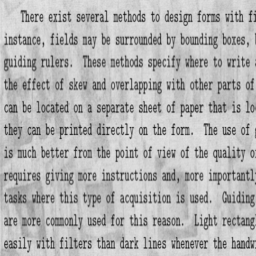

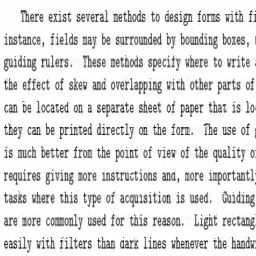

2021-08-04 20:02:14.207296 Epoch 420, Training loss 0.00020307914484065905


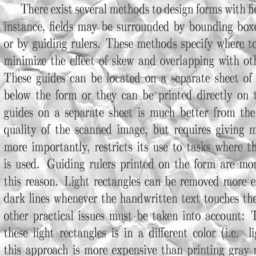

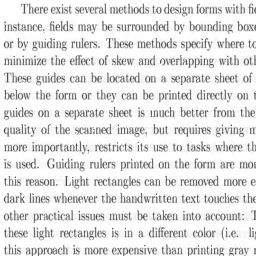

2021-08-04 20:02:29.953522 Epoch 430, Training loss 0.00018708286329961589


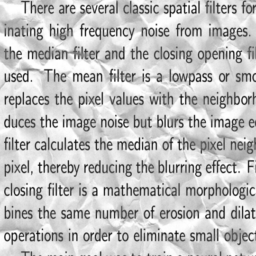

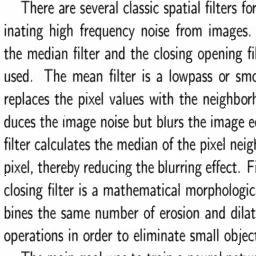

2021-08-04 20:02:45.697352 Epoch 440, Training loss 0.00016776786085554503


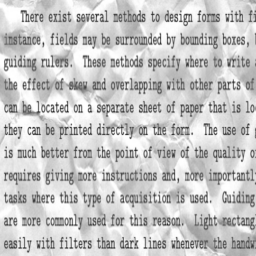

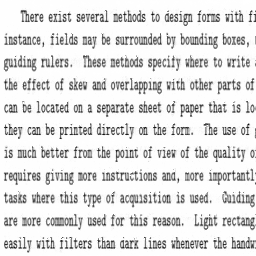

2021-08-04 20:03:01.414825 Epoch 450, Training loss 0.00015281757825707446


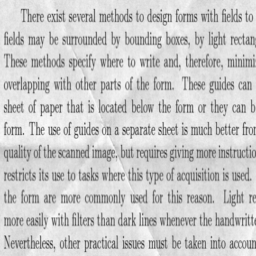

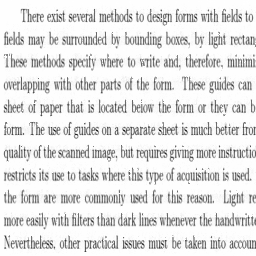

2021-08-04 20:03:17.150405 Epoch 460, Training loss 0.00013926191584485222


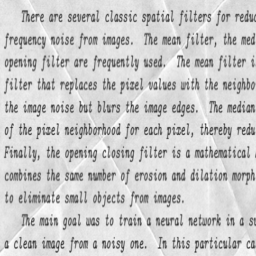

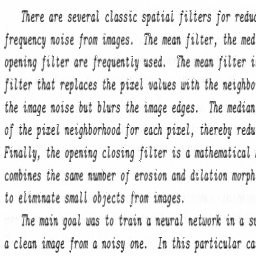

2021-08-04 20:03:32.904105 Epoch 470, Training loss 0.00012899338798888493


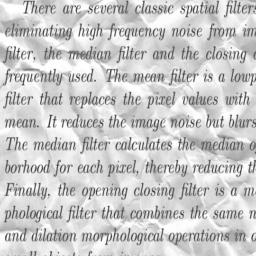

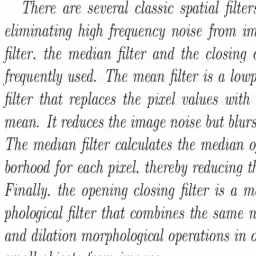

2021-08-04 20:03:48.635090 Epoch 480, Training loss 0.00011693793547035764


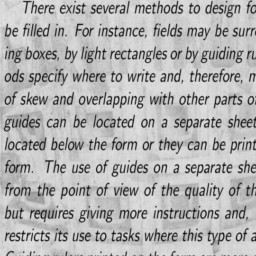

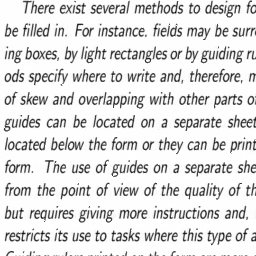

2021-08-04 20:04:04.396280 Epoch 490, Training loss 0.00010847938978662973


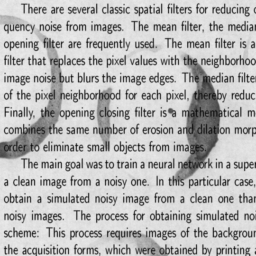

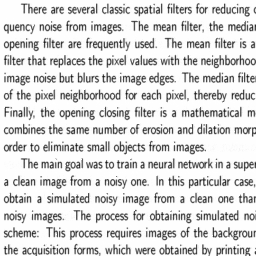

2021-08-04 20:04:20.136573 Epoch 500, Training loss 0.00010610933612851013


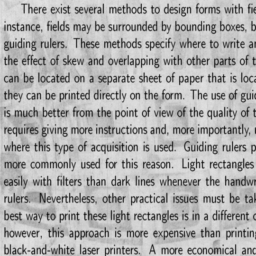

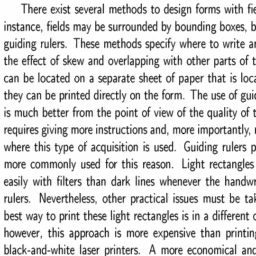

In [ ]:
errors_cnn0, accuracies_cnn0 = training_loop( 
    n_epochs = 500,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    index_loader = index_loader,
    t_cleaned = tensor_cleaned,
    t_train = tensor_train,
    features = shape_img,
    )

In [ ]:
model = AutoencoderMLP(input_shape=shape_img[0]*shape_img[1]).to(device)
model.load_state_dict(torch.load(path_models+"autoencoder_mlp1.pt"), strict=False)

<All keys matched successfully>

In [ ]:
errors_cnn0 = np.array(errors_cnn0)

In [ ]:
#ind_max_lin = np.argmax(accuracies_cnn0[:, 1]) 
#max_lin = np.max(accuracies_cnn0[:, 1])
plt.plot(errors_cnn0)
plt.xlabel("Época x 10")
plt.ylabel("Error sobre entrenamiento")
#plt.text(ind_max_lin + .2, 0.6, 'época='+str(ind_max_lin))
#plt.text(ind_max_lin + .2, 0.4, 'error='+str(errors_cnn0[ind_max_lin]))
#plt.vlines(ind_max_lin, 0, max_lin, linestyles='dashed', colors='red', label="Highest Accuracy")
plt.title("Error por MLP Shallow Undercome")
plt.show()

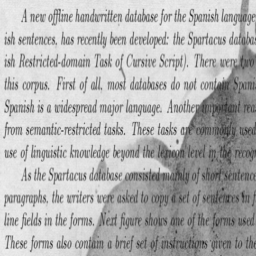

torch.Size([1, 65536])


ValueError: ignored

In [ ]:
tran1_tmp = transforms.ToPILImage()
cont = 0
for img in data_test:
  display(tran1_tmp(img))
  img = img.view(-1, 256*256).to(device)
  print(img.shape)
  out = model(img)
  out = out.view(256,256).to("cpu")
  display(tran1_tmp(out))
  cont += 1
  if cont == 5:
    break

In [ ]:
img = data_train[0]
img = img.view(-1, 420*540).to(device)

In [ ]:
out = model(img)
out = out.view(420,540).to("cpu")
out.shape

torch.Size([420, 540])

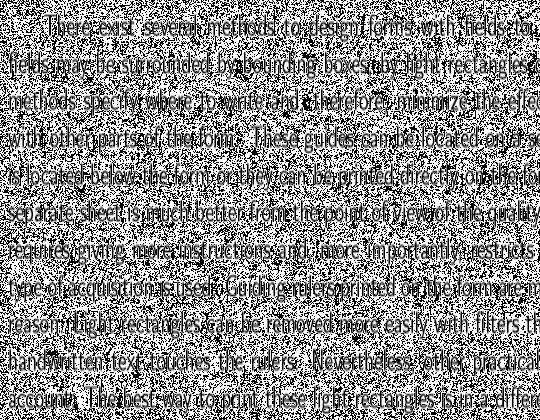

In [ ]:
tran1_tmp = transforms.ToPILImage()
tran1_tmp(out)